<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Начало-блока-объявления-функций" data-toc-modified-id="Начало-блока-объявления-функций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Начало блока объявления функций</a></span></li><li><span><a href="#Конец-блока-объявления-функций" data-toc-modified-id="Конец-блока-объявления-функций-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Конец блока объявления функций</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle

### Начало блока объявления функций

In [ ]:
def balance_info(x):
    print('Баланс классов в целевом признаке')
    print('-'*33)
    print(x.value_counts(normalize=True))
    print('-'*33)

In [ ]:
def create_splits(features, target, type=None):
    if type=='ohe':
        features_train_ohe, features_pack, target_train_ohe, target_pack = train_test_split(
          features, target, test_size=0.4, random_state=12345, stratify = target)
        features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
          features_pack, target_pack, test_size=0.5, random_state=12345, stratify = target_pack)
        print('Прямое кодирование','\n', 'Обучающая выборка:', features_train_ohe.shape, target_train_ohe.shape,'\n',
          'Валидационная выборка:', features_valid_ohe.shape, target_valid_ohe.shape,'\n',
          'Тестовая выборка:', features_test_ohe.shape, target_test_ohe.shape)
        return features_train_ohe, target_train_ohe, features_valid_ohe,\
          target_valid_ohe, features_test_ohe, target_test_ohe
    elif type=='ordinal':
        features_train_ordinal, features_pack, target_train_ordinal, target_pack = train_test_split(
          features, target, test_size=0.4, random_state=12345, stratify = target)
        features_valid_ordinal, features_test_ordinal, target_valid_ordinal, target_test_ordinal = train_test_split(
          features_pack, target_pack, test_size=0.5, random_state=12345, stratify = target_pack)
        print('Порядковое кодирование','\n', 'Обучающая выборка:', features_train_ordinal.shape,
              target_train_ordinal.shape,'\n', 
              'Валидационная выборка:', features_valid_ordinal.shape, target_valid_ordinal.shape,'\n',
              'Тестовая выборка:', features_test_ordinal.shape, target_test_ordinal.shape)
        return features_train_ordinal, target_train_ordinal, features_valid_ordinal,\
          target_valid_ordinal, features_test_ordinal, target_test_ordinal
    else:
      print('type ohe or ordinal')

In [ ]:
def zeroing():
    global best_tree, best_forest, best_logistic, f1_tree, f1_forest
    global f1_logistic, auc_roc_tree, auc_roc_forest, auc_roc_logistic
    best_tree, best_forest, best_logistic = 0, 0, 0
    f1_tree, f1_forest, f1_logistic = 0, 0, 0
    auc_roc_tree, auc_roc_forest, auc_roc_logistic = 0, 0, 0

In [ ]:
def create_best_tree(features_train, target_train, features_valid, target_valid, class_weight=None):
    global best_tree, f1_tree, auc_roc_tree
    for depth in range(1, 20):
        model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > f1_tree:
            best_tree = model
            f1_tree = f1
            auc_roc_tree = roc
    print(' Характеристики лучшего дерева:', best_tree, '\n', 'Лучшее значение f1:',
          f1_tree, '\n', 'Лучшее значение AUC-ROC:', auc_roc_tree)

In [ ]:
def create_best_forest(features_train, target_train, features_valid, target_valid, class_weight=None):
    global best_forest, f1_forest, auc_roc_forest
    best_depth = 0
    best_estimators = 0
    for depth in range(1, 20):
        model = RandomForestClassifier(
            max_depth=depth, 
            random_state=12345, 
            class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > f1_forest:
            best_forest = model
            f1_forest = f1
            auc_roc_forest = roc
            best_depth = depth
    for n_estimators in range(1, 100, 5):
        model = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=best_depth, 
            random_state=12345, 
            class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > f1_forest:
            best_forest = model
            f1_forest = f1
            auc_roc_forest = roc
            best_estimators = n_estimators
    est_one = best_estimators-5
    est_two = best_estimators+5
    for n_estimators in range(est_one, est_two):
        model = RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=best_depth, 
            random_state=12345, 
            class_weight=class_weight)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        roc = roc_auc_score(target_valid, probabilities_one_valid)
        if f1 > f1_forest:
            best_forest = model
            f1_forest = f1
            auc_roc_forest = roc
            best_estimators = n_estimators
    print(' Характеристики лучшего леса:', best_forest, '\n', 'Лучшее значение f1:',
          f1_forest, '\n', 'Лучшее значение AUC-ROC:', auc_roc_forest)

In [ ]:
def create_best_logistic(features_train, target_train, features_valid, target_valid, class_weight=None):
    model = LogisticRegression(solver='liblinear', class_weight=class_weight)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(' Результаты логистической регрессии', '\n', 'Лучшее значение f1:',
          f1, '\n', 'Лучшее значение AUC-ROC:', roc)

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

### Конец блока объявления функций

In [ ]:
plt.style.use('dark_background')

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank_ml/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [ ]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'rownumber':'row_number', 'customerid':'customer_id', 'creditscore':'credit_score', 
                   'numofproducts':'num_of_products', 'hascrcard':'has_cr_card', 
                   'isactivemember':'is_active_member', 'estimatedsalary':'estimated_salary'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Признаки**  
Row_Number — индекс строки в данных  
Customer_Id — уникальный идентификатор клиента  
Surname — фамилия  
Credit_Score — кредитный рейтинг  
Geography — страна проживания  
Gender — пол  
Age — возраст  
Tenure — сколько лет человек является клиентом банка  
Balance — баланс на счёте  
Num_Of_Products — количество продуктов банка, используемых клиентом  
Has_Cr_Card — наличие кредитной карты  
Is_Active_Member — активность клиента  
Estimated_Salary — предполагаемая зарплата  
**Целевой признак**  
Exited — факт ухода клиента  

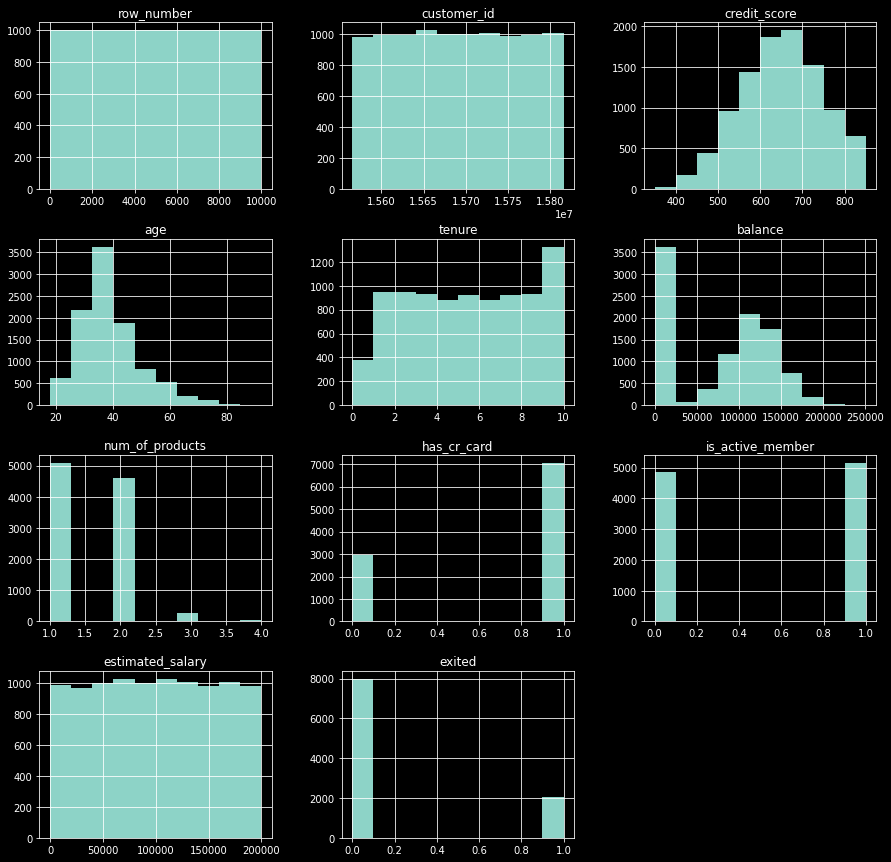

In [ ]:
df.hist(figsize=(15,15));

In [ ]:
for i in ['surname', 'geography', 'gender']:
    df[i] = df[i].str.lower()

In [ ]:
print('количество дубликатов:', df.duplicated().sum())

количество дубликатов: 0


In [ ]:
print('количество пропусков:', df['tenure'].isna().sum())

количество пропусков: 909


In [ ]:
df.index = df['customer_id']
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [ ]:
print('Количество уникальных значений в каждом столбце')
print('-'*25)
print(df.nunique())
print('-'*25)

Количество уникальных значений в каждом столбце
-------------------------
credit_score         460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
num_of_products        4
has_cr_card            2
is_active_member       2
estimated_salary    9999
exited                 2
dtype: int64
-------------------------


In [ ]:
for i in df.columns:
    print(f'Минимальное значение в столбце {i}:', df[i].dropna().unique().min())
    print(f'Максимальное значение в столбце {i}:', df[i].dropna().unique().max(), '\n')

Минимальное значение в столбце credit_score: 350
Максимальное значение в столбце credit_score: 850 

Минимальное значение в столбце geography: france
Максимальное значение в столбце geography: spain 

Минимальное значение в столбце gender: female
Максимальное значение в столбце gender: male 

Минимальное значение в столбце age: 18
Максимальное значение в столбце age: 92 

Минимальное значение в столбце tenure: 0.0
Максимальное значение в столбце tenure: 10.0 

Минимальное значение в столбце balance: 0.0
Максимальное значение в столбце balance: 250898.09 

Минимальное значение в столбце num_of_products: 1
Максимальное значение в столбце num_of_products: 4 

Минимальное значение в столбце has_cr_card: 0
Максимальное значение в столбце has_cr_card: 1 

Минимальное значение в столбце is_active_member: 0
Максимальное значение в столбце is_active_member: 1 

Минимальное значение в столбце estimated_salary: 11.58
Максимальное значение в столбце estimated_salary: 199992.48 

Минимальное значен

In [ ]:
df['estimated_salary'].sort_values().head(10)

customer_id
15791053     11.58
15679693     90.07
15786463     91.75
15639662     96.27
15602851    106.67
15623369    123.07
15648735    142.81
15718667    143.34
15640421    178.19
15684198    216.27
Name: estimated_salary, dtype: float64

In [ ]:
df = df.drop(axis=0, index=15791053)

In [ ]:
balance_info(df['exited'])

Баланс классов в целевом признаке
---------------------------------
0    0.79638
1    0.20362
Name: exited, dtype: float64
---------------------------------


In [ ]:
df = df.dropna()
df_ohe = pd.get_dummies(df, drop_first=True)#.dropna()
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df), columns=df.columns)#.dropna()

In [ ]:
features_ohe = df_ohe.drop('exited', axis=1)
target_ohe = df_ohe['exited']
features_ordinal = df_ordinal.drop('exited', axis=1)
target_ordinal = df_ordinal['exited']

In [ ]:
features_train_ohe, target_train_ohe, features_valid_ohe,\
 target_valid_ohe, features_test_ohe, target_test_ohe = create_splits(features_ohe, target_ohe, 'ohe')

Прямое кодирование 
 Обучающая выборка: (5454, 11) (5454,) 
 Валидационная выборка: (1818, 11) (1818,) 
 Тестовая выборка: (1818, 11) (1818,)


In [ ]:
features_train_ordinal, target_train_ordinal, features_valid_ordinal,\
 target_valid_ordinal, features_test_ordinal, target_test_ordinal = create_splits(
    features_ohe, target_ohe, 'ordinal')

Порядковое кодирование 
 Обучающая выборка: (5454, 11) (5454,) 
 Валидационная выборка: (1818, 11) (1818,) 
 Тестовая выборка: (1818, 11) (1818,)


В процессе подготовки данных, были осуществлены следующие действия:  
1. Визуально осмотрен набор данных  
  Вывод:  
    - Названия столбцов необходимо привести к змеиному регистру - **Выполнено**  
    - Столбец *customer_id* можно сделать столбцом индекса - **Выполнено**  
    - Столбцы *row_number, surname* будут мешать при обучении модели, решено удалить - **Выполнено**  
    - Форматы данных устраивают
    - Присутствуют пропуски в столбце *tenure*
    - Выбросы и аномалии не обнаружены
    - Присутствует дисбаланс классов в целевом признаке
2. Строки в столбцах *surname, geography, gender* приведены к нижнему регистру для проверки на дубликаты.
    - Дубликатов не обнаружено
3. Посчитаны пропуски в столбце *tenure* - 909 шт. Решено оставить как есть. Заполнение какими либо значениями может исказить данные, удаление приведет к потере данных.  
        *Оказалось, модель не обрабатывает пропуски, придется исключить их из выборок для моделей
4. Проведен осмотр уникальных значений в столбцах, обнаружена одна аномалия: предполагаемая зарплата составляет 11 евро. - **Строка удалена**
5. Проверен баланс классов целевого признака, он составляет:  
    - Не ушедших клиентов - 80%  
    - Ушедших клиентов - 20%
6. Созданы 2 датафрейма для дальнейшего построения моделей:
    - техникой прямого кодирования (One-Hot Encoding, OHE)
    - техникой порядкового кодирования по номеру категории(Ordinal Encoding)
7. Подготовлены выборки для обучения и проверки моделей

## Исследование задачи

In [ ]:
zeroing()

In [ ]:
create_best_tree(features_train_ordinal, target_train_ordinal, 
                 features_valid_ordinal, target_valid_ordinal)  

 Характеристики лучшего дерева: DecisionTreeClassifier(max_depth=7, random_state=12345) 
 Лучшее значение f1: 0.5539452495974235 
 Лучшее значение AUC-ROC: 0.7899231982892386


In [ ]:
create_best_forest(features_train_ordinal, target_train_ordinal, 
                   features_valid_ordinal, target_valid_ordinal)


 Характеристики лучшего леса: RandomForestClassifier(max_depth=17, n_estimators=89, random_state=12345) 
 Лучшее значение f1: 0.561344537815126 
 Лучшее значение AUC-ROC: 0.8266391847059722


In [ ]:
create_best_logistic(features_train_ohe, target_train_ohe, 
                     features_valid_ohe, target_valid_ohe)

 Результаты логистической регрессии 
 Лучшее значение f1: 0.14898419864559817 
 Лучшее значение AUC-ROC: 0.6744468060137434


|Модель                 |F1      |ROC-AUC              |
|:---------------------:|:------:|:-------------------:|
|Решающее дерево        |0.5539  |0.8147               |
|                       |        |                     |
|Случайный лес          |0.5613  |0.8266               |
|                       |        |                     |
|Логистическая регрессия|0.1489  |0.6744               |  


Ни одна модель не показала удовлетворительных результатов. Следует продолжить эксперименты в поисках лучшей модели удовлетворяющей условиям задачи. В первую очередь необходимо избавится от дисбаланса классов.

## Борьба с дисбалансом

In [ ]:
features_train_ohe_upsampled, target_train_ohe_upsampled = upsample(
    features_train_ohe, target_train_ohe, 4)
features_train_ordinal_upsampled, target_train_ordinal_upsampled = upsample(
    features_train_ordinal, target_train_ordinal, 4)

In [ ]:

balance_info(target_train_ohe_upsampled)

Баланс классов в целевом признаке
---------------------------------
1    0.50603
0    0.49397
Name: exited, dtype: float64
---------------------------------


In [ ]:
scaler = StandardScaler()
scaler.fit(features_train_ordinal)
features_train_ordinal = scaler.transform(features_train_ordinal)
features_valid_ordinal = scaler.transform(features_valid_ordinal)
features_test_ordinal = scaler.transform(features_test_ordinal)
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)
features_valid_ohe = scaler.transform(features_valid_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

Использовав метод upsampling'а удалось придти к балансу классов. Не пришлось применять downsampling. Дополнительно проведено масштабирование. Далее будет проведен эксперимент основанный на результатах upsampling'а.

In [ ]:
zeroing()

In [ ]:
create_best_tree(features_train_ordinal_upsampled, target_train_ordinal_upsampled, 
                 features_valid_ordinal, target_valid_ordinal)  

 Характеристики лучшего дерева: DecisionTreeClassifier(max_depth=4, random_state=12345) 
 Лучшее значение f1: 0.3016476552598225 
 Лучшее значение AUC-ROC: 0.5153342634728977


In [ ]:
create_best_forest(features_train_ordinal_upsampled, target_train_ordinal_upsampled, 
                   features_valid_ordinal, target_valid_ordinal)


 Характеристики лучшего леса: RandomForestClassifier(max_depth=3, n_estimators=26, random_state=12345) 
 Лучшее значение f1: 0.43478260869565216 
 Лучшее значение AUC-ROC: 0.6967021647166645


In [ ]:
create_best_logistic(features_train_ohe_upsampled, target_train_ohe_upsampled, 
                     features_valid_ohe, target_valid_ohe)

 Результаты логистической регрессии 
 Лучшее значение f1: 0.44745762711864406 
 Лучшее значение AUC-ROC: 0.7359272926419006


In [ ]:
zeroing()

In [ ]:
create_best_tree(features_train_ordinal, target_train_ordinal, 
                 features_valid_ordinal, target_valid_ordinal, class_weight='balanced')   

 Характеристики лучшего дерева: DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345) 
 Лучшее значение f1: 0.5280665280665281 
 Лучшее значение AUC-ROC: 0.7935499974852702


In [ ]:
create_best_forest(features_train_ordinal, target_train_ordinal, 
                   features_valid_ordinal, target_valid_ordinal, class_weight='balanced')

 Характеристики лучшего леса: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=31,
                       random_state=12345) 
 Лучшее значение f1: 0.5922974767596282 
 Лучшее значение AUC-ROC: 0.8396291611792778


In [ ]:
create_best_logistic(features_train_ohe, target_train_ohe, 
                     features_valid_ohe, target_valid_ohe, class_weight='balanced')

 Результаты логистической регрессии 
 Лучшее значение f1: 0.4903846153846154 
 Лучшее значение AUC-ROC: 0.7550336508102087


|Модель|upsample|class_weight|F1|ROC-AUC|
|:-:|:-:|:-:|:-:|:-:|
|Решающее дерево|-|-|0.5539|0.8147|
||+|-|0.3016|0.5153|
||+|+|0.5280|0.7935|
|Случайный лес|-|-|0.5613|0.8266|
||+|-|0.4347|0.6967|
||+|+|**0.5922**|**0.8396**| 
|Логистическая регрессия|-|-|0.1489|0.6744|
||+|-|0.4474|0.7359|
||+|+|0.4903|0.7550|

Лучшие результаты показывает случайный лес при применении:
  - upsample - позволяет избавиться от дисбаланса классов
  - scaler - преобразование масштаба методом стандартизации
  - class_weight - взвешивание классов  
    
После их применения мы получаем: 
  - F1 - среднее гармоническое полноты и точности - 0.5922
  - AUC-ROC - Площадь под ROC-кривой - 0.8396

## Тестирование модели

In [ ]:
predicted_valid = best_forest.predict(features_test_ordinal)
f1 = f1_score(target_test_ordinal, predicted_valid)
probabilities_valid = best_forest.predict_proba(features_test_ordinal)
probabilities_one_valid = probabilities_valid[:, 1]
roc = roc_auc_score(target_test_ordinal, probabilities_one_valid)
print('Значение f1:', f1, '\n', 'Значение AUC-ROC:', roc)

Значение f1: 0.6463104325699747 
 Значение AUC-ROC: 0.8718903986859788


Модель готова. Красавица. Можно применять в банке.

 Полученные исторические данные были изучены и подготовлены к обучению модели машинного обучения. Для удобства имена столбцов были приведены к змеиному регистру. Данные прошли проверку на пропуски и дубликаты, были удалены лишние столбцы и созданы 2 набора выборок используя порядковое и прямое кодирование. Обнаружен сильный дисбаланс классов целевого признака. Далее был проведен эксперимент по созданию 3-х видов моделей не устраняя дисбаланса, что очевидно показало невозможность создания качественной модели при присутствующем дисбалансе. После чего дисбаланс был устранен при помощи метода upsampling, а также проведено масштабирование. И снова был проведен эксперимент по созданию моделей, при этом сравнивались модели с использованием взвешивания классов и без него. В итоге лучшие результаты показала модель случайного леса с использованием взвешивания, масштабирования, upsampling'а и порядкового кодирования. С таким набором было достигнуто значение f1 - 0.64 на тестовой выборке, что удовлетворяет требованию задачи f1 > 0.59, также площадь под ROC-кривой составила 0.87 - это доказывает что модель далека от случайной.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*